In [32]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import gym
import gym_safety
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from stable_baselines import PPO2
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.evaluation import evaluate_policy
from stable_baselines import results_plotter
from stable_baselines.bench import Monitor
from stable_baselines.common.callbacks import BaseCallback

In [33]:
# Create log dir
log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)

In [34]:
env = gym.make('CartSafe-v0')
env = Monitor(env, log_dir)

/usr/local/Caskroom/miniconda/base/envs/safety-basic/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [35]:
ppo_model = PPO2('MlpPolicy', env, verbose=1, tensorboard_log="logs")

Wrapping the env in a DummyVecEnv.


In [39]:
class EvaluateSafetyCallback(BaseCallback):
    def __init__(self, verbose=0):
        self.is_tb_set = False
        super(TensorboardCallback, self).__init__(verbose)

    def _on_step(self) -> bool:
        # Log additional tensor
        if not self.is_tb_set:
            with self.model.graph.as_default():
                tf.summary.scalar('value_target', tf.reduce_mean(self.model.value_target))
                self.model.summary = tf.summary.merge_all()
            self.is_tb_set = True
        # Log scalar value (here a random variable)
        value = np.random.random()
        summary = tf.Summary(value=[tf.Summary.Value(tag='random_value', simple_value=value)])
        self.locals['writer'].add_summary(summary, self.num_timesteps)
        return True

In [36]:
# Train the agent
ppo_model.learn(total_timesteps=int(8e4), log_interval=10, tb_log_name='ppo', callback=EvaluateSafetyCallback())
# Save the agent
ppo_model.save("ppo_constraint")

# Load the model
#ppo_model.load('ppo_constraint')

---------------------------------------
| approxkl           | 5.6404086e-05  |
| clipfrac           | 0.0            |
| explained_variance | 0.0251         |
| fps                | 336            |
| n_updates          | 1              |
| policy_entropy     | 0.6930691      |
| policy_loss        | -0.00036483363 |
| serial_timesteps   | 128            |
| time_elapsed       | 2.1e-05        |
| total_timesteps    | 128            |
| value_loss         | 177.58714      |
---------------------------------------
--------------------------------------
| approxkl           | 9.912846e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 178           |
| ep_reward_mean     | 239           |
| explained_variance | 0.0645        |
| fps                | 1419          |
| n_updates          | 10            |
| policy_entropy     | 0.6869541     |
| policy_loss        | 0.00043372146 |
| serial_timesteps   | 1280          |
| time_elapsed       | 1.11          |
| total_time

In [37]:
mean_reward, std_reward = evaluate_policy(ppo_model, env, n_eval_episodes=100)
print(mean_reward, std_reward)

93.85444280293633 3.8701233156195616


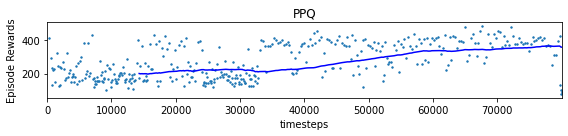

In [38]:
results_plotter.plot_results([log_dir], 8e4, results_plotter.X_TIMESTEPS, "PPQ")
plt.show()

In [22]:
#env = DummyVecEnv([lambda: gym.make('CartSafe-v0')])
history = []

# Record the video starting at the first step
#video_folder = 'logs/videos/'
#video_length = 100
#env = VecVideoRecorder(env, video_folder,
#                       record_video_trigger=lambda x: x == 0, video_length=video_length,
#                       name_prefix="dqn-agent")

for _ in range(5): #episodes
    episode = []
    _ = env.reset()
    for _ in range(100): #timesteps
        obs = env.reset()
        action, _ = ppo_model.predict(obs)
        obs, reward, done, info = env.step(action)
        episode.append([obs, reward, done, info])
        env.render()
        #print(f"{obs}\n {reward}\n {done}\n {info}\n")
    history.append(episode)
    env.close()


def get_constraint_cost(episode):
    return list(episode[k][3].get('constraint_costs')[0] for k in range(len(episode)))

def evaluate_safety(history):
    constraint_cost = [get_constraint_cost(history[k]) for k in range(len(history))]
    for i, cost in enumerate(constraint_cost):
        plt.plot(cost, label=str(i))
        
    plt.legend()
    plt.show()
    
evaluate_safety(history)